In [1]:
import lasagne
import theano
import theano.tensor as T
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator import get_batch, print_valid_characters
%matplotlib inline 
%matplotlib nbagg

/Users/casperkaae/Documents/phd/lib/nntools/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


# Recurrent Neural Networks
In this exercise we'll implement a Encoder-Decoder RNN based on the GRU unit. This types of models have shown impressive performance in Neural Machine Translation and Image Caption generation.


# Encoder-Decoder
In the encoder-decoder structure one RNN (blue) encodes the input and a second RNN (red) calculates the target values. One essential step is to let the encoder and decoder communicate. In the simplest approach you use the last hidden state of the encoder to initialize the decoder. Other approaches lets the decoder attend to different parts of the encoded input at different timesteps in the decoding process. 

<img src="files/enc-dec.png", width=400>

In our implementation we use a RNN with gated recurrent units (GRU) as encoder. We then use the last hidden state of the encoder ($h^{enc}_T$) as input to the decoder which is also a GRU RNN. 

### RNNs in Lasagne
Lasagne have implementations of LSTM and GRU unit. Both layers assume that the input from the ayer below have the shape **(Batch_size, seq_len, num_features)**. In this excercise we will use the GRU unit since it only stores a single hidden value per neuran (LSTMs stores two). This both make the implementation cleaner and faster to run.

For ease of implementation we'll create a RepeatLayer that repeats  $h^{enc}_T$ number-of-decoder-step times. That is for each step in the decoder we always use $h^{enc}_T$. Below is an implementation of the RepeatLayer. If you are not sure what RepeatLayer does try run some data thrugh the layer and see what happens.


In [2]:
class RepeatLayer(lasagne.layers.Layer):
    def __init__(self, incoming, n, **kwargs):
        '''
        The input is expected to be a 2D tensor of shape 
        (num_batch, num_features). The input is repeated
        n times such that the output will be 
        (num_batch, n, num_features)
        '''
        super(RepeatLayer, self).__init__(incoming, **kwargs)
        self.n = n

    def get_output_shape_for(self, input_shape):
        return tuple([input_shape[0], self.n] + list(input_shape[1:]))

    def get_output_for(self, input, **kwargs):
        tensors = [input]*self.n
        stacked = theano.tensor.stack(*tensors)
        dim = [1, 0] + range(2, input.ndim + 1)
        return stacked.dimshuffle(dim)

### The Data
Since RNN models can be very slow to train on real large datasets we will generate some simpler test data for this exercise. The task for the RNN is simply to translate a string of letters spelling the numbers between 0-9 into the corresponding numbers i.e

"one two five" --> "125#" (we use # as a special stop of sequence character)

To input the strings into the RNN model we translate the characters into a vector integers using a imple translation table (i.e. 'h'->16, 'o'-> 17 etc). The code below prints a few input/output pairs using the *get_batch* function

In [3]:
batch_size = 3
inputs, input_masks, targets, target_masks, text_inputs, text_targets = \
    get_batch(batch_size=batch_size,max_digits=2,min_digits=1)

print inputs.dtype,  input_masks.dtype, targets.dtype, target_masks.dtype
    
print print_valid_characters()
print "Stop character = #"


for i in range(batch_size):
    print "\nSAMPLE",i
    print "TEXT INPUTS:\t\t", text_inputs[i]
    print "TEXT TARGETS:\t\t", text_targets[i]
    print "ENCODED INPUTS:\t\t", inputs[i]
    print "MASK INPUTS:\t\t", input_masks[i]
    print "ENCODED TARGETS:\t", targets[i]
    print "MASK TARGETS:\t\t", target_masks[i]

int32 float32 int32 float32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	' '=11,	'e'=12,	'g'=13,	'f'=14,	'i'=15,	'h'=16,	'o'=17,	'n'=18,	's'=19,	'r'=20,	'u'=21,	't'=22,	'w'=23,	'v'=24,	'x'=25,	'z'=26,	
None
Stop character = #

SAMPLE 0
TEXT INPUTS:		three
TEXT TARGETS:		3#
ENCODED INPUTS:		[22 16 20 12 12]
MASK INPUTS:		[ 1.  1.  1.  1.  1.]
ENCODED TARGETS:	[ 3 10  0]
MASK TARGETS:		[ 1.  1.  0.]

SAMPLE 1
TEXT INPUTS:		seven
TEXT TARGETS:		7#
ENCODED INPUTS:		[19 12 24 12 18]
MASK INPUTS:		[ 1.  1.  1.  1.  1.]
ENCODED TARGETS:	[ 7 10  0]
MASK TARGETS:		[ 1.  1.  0.]

SAMPLE 2
TEXT INPUTS:		eight
TEXT TARGETS:		8#
ENCODED INPUTS:		[12 15 13 16 22]
MASK INPUTS:		[ 1.  1.  1.  1.  1.]
ENCODED TARGETS:	[ 8 10  0]
MASK TARGETS:		[ 1.  1.  0.]


### Encoder Decoder model setup
Below is the lasagne model definition. A litle tricky implementation detail is that the model is split between a encoder part(taking X as input) and a decoder part (taking the output of the encoder as input). This is not strickly nescessary, but however allows us to use masks for both the inputs and the targets allowing varying length of both.

In [4]:
BATCH_SIZE = 100
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10
MAX_DIGITS = 20 
MIN_DIGITS = MAX_DIGITS #currently only support for same length outputs - we'll leave it for an exercise to add support for varying length targets
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')


#symbolic theano variables. Note that we are using imatrix for X since it goes into the embedding layer
x_sym = T.imatrix()
y_sym = T.imatrix()
xmask_sym = T.matrix()

#dummy data to test implementation
#X = np.random.randint(0,10,size=(BATCH_SIZE,15)).astype('int32')
#Xmask = np.ones((BATCH_SIZE,NUM_INPUTS)).astype('float32')

##### ENCODER START #####
l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
#Here we'll remove the trainable parameters from the embeding layer to constrain 
#it to a simple "one-hot-encoding". You can experiment with removing this line
l_emb.params[l_emb.W].remove('trainable') 

#print lasagne.layers.get_output(l_emb, x_sym).eval({x_sym: X}).shape

l_enc = lasagne.layers.GRULayer(l_emb, num_units=NUM_UNITS_ENC, name='GRUEncoder')
#print lasagne.layers.get_output(l_enc, x_sym, mask=xmask_sym).eval({x_sym: X, xmask_sym:Xmask}).shape

# slice last index of dimension 1
l_last_hid = lasagne.layers.SliceLayer(l_enc, indices=-1, axis=1)
##### END OF ENCODER######


##### START OF DECODER######
#note that the decoder have its own input layer, we'll use that to plug in the output 
#from the encoder later
l_in_dec = lasagne.layers.InputLayer(l_last_hid.output_shape) 
l_in_rep = RepeatLayer(l_in_dec, n=MAX_DIGITS+1) #we add one to allow space for the end of sequence character
l_dec = lasagne.layers.GRULayer(l_in_rep, num_units=NUM_UNITS_DEC, name='GRUDecoder')

# We need to do some reshape voodo to connect a softmax layer to the decoder.
# See http://lasagne.readthedocs.org/en/latest/modules/layers/recurrent.html#examples 
# In short this line changes the shape from 
# (batch_size, decode_len, num_dec_units) -> (batch_size*decodelen,num_dec_units). 
# We need to do this since the softmax is applied to the last dimension and we want to 
# softmax the output at each position individually
l_reshape = lasagne.layers.ReshapeLayer(l_dec, (-1, [2]))
#print lasagne.layers.get_output(l_reshape, x_sym).eval({x_sym: X}).shape
l_softmax = lasagne.layers.DenseLayer(l_reshape, num_units=NUM_OUTPUTS, 
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      name='SoftmaxOutput')
# print lasagne.layers.get_output(l_softmax, x_sym).eval({x_sym: X}).shape
# reshape back to 3d format (batch_size, decode_len, num_dec_units). Here we tied the batch size to the shape of the symbolic variable for X allowing 
#us to use different batch sizes in the model.
l_out = lasagne.layers.ReshapeLayer(l_softmax, (x_sym.shape[0], -1, NUM_OUTPUTS))
###END OF DECODER######


### Defining the cost function and theano functions
Becasue the targets are categorical we use cross entropy error. We use the Adam optimizer but you
can experiment with the different optimizers implemented in [Lasagne](http://lasagne.readthedocs.org/en/latest/modules/updates.html). 

In [5]:
#get output of encoder using X and Xmask as input
output_encoder_train = lasagne.layers.get_output(l_last_hid, x_sym, mask=xmask_sym, deterministic=False,)
#get output of decoder using the encoder as input
output_decoder_train = lasagne.layers.get_output(l_out, output_encoder_train, deterministic=False)


#cost function
total_cost = T.nnet.categorical_crossentropy(
    T.reshape(output_decoder_train, (-1, NUM_OUTPUTS)), y_sym.flatten())
mean_cost = T.mean(total_cost)
#accuracy function
acc = T.mean(T.eq(T.argmax(output_decoder_train,axis=-1),y_sym))

#Get parameters of both encoder and decoder
all_parameters = lasagne.layers.get_all_params([l_last_hid, l_out], trainable=True)


print "Trainable Model Parameters"
print "-"*40
for param in all_parameters:
    print param, param.get_value().shape
print "-"*40

#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(mean_cost, all_parameters)]

#Compile Theano functions
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)
train_func = theano.function([x_sym, y_sym, xmask_sym], [mean_cost, acc, output_decoder_train], updates=updates)
#since we don't have any stochasticity in the network we will just use the training graph without any updates given
test_func = theano.function([x_sym, y_sym, xmask_sym], [acc, output_decoder_train])

/Users/casperkaae/Documents/phd/lib/nntools/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "
/Users/casperkaae/anaconda/lib/python2.7/site-packages/theano/scan_module/scan.py:1018: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)
/Users/casperkaae/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:134: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (27, 10)
GRUEncoder.W_hid_to_updategate (10, 10)
GRUEncoder.b_updategate (10,)
GRUEncoder.W_in_to_resetgate (27, 10)
GRUEncoder.W_hid_to_resetgate (10, 10)
GRUEncoder.b_resetgate (10,)
GRUEncoder.W_in_to_hidden_update (27, 10)
GRUEncoder.W_hid_to_hidden_update (10, 10)
GRUEncoder.b_hidden_update (10,)
GRUEncoder.hid_init (1, 10)
GRUDecoder.W_in_to_updategate (10, 10)
GRUDecoder.W_hid_to_updategate (10, 10)
GRUDecoder.b_updategate (10,)
GRUDecoder.W_in_to_resetgate (10, 10)
GRUDecoder.W_hid_to_resetgate (10, 10)
GRUDecoder.b_resetgate (10,)
GRUDecoder.W_in_to_hidden_update (10, 10)
GRUDecoder.W_hid_to_hidden_update (10, 10)
GRUDecoder.b_hidden_update (10,)
GRUDecoder.hid_init (1, 10)
SoftmaxOutput.W (10, 11)
SoftmaxOutput.b (11,)
----------------------------------------


In [6]:
#Generate some validation data
Xval, Xmask_val, Yval, Ymask_val, _, _ = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)

### Do training

In [7]:
NUM_UPDATES = 100000
val_interval = 5000
samples_processed = 0
val_samples = []
costs, accs = [], []
for n in range(NUM_UPDATES):
    inputs, input_masks, targets, target_masks, _, _ = \
        get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
    batch_cost, batch_acc, batch_output = train_func(inputs, targets, input_masks)
    costs += [batch_cost]
    samples_processed += BATCH_SIZE
    #print i, samples_processed
    #validation data
    if samples_processed % val_interval == 0:
        #print "validating"
        batch_acc, batch_output = test_func(Xval, Yval, Xmask_val)
        val_samples += [samples_processed]
        accs += [batch_acc]
        plt.plot(val_samples,accs)
        plt.ylabel('Val Acc', fontsize=20)
        plt.xlabel('Processed samples', fontsize=20)
        plt.title('Val ACC', fontsize=25)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.show()
        

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


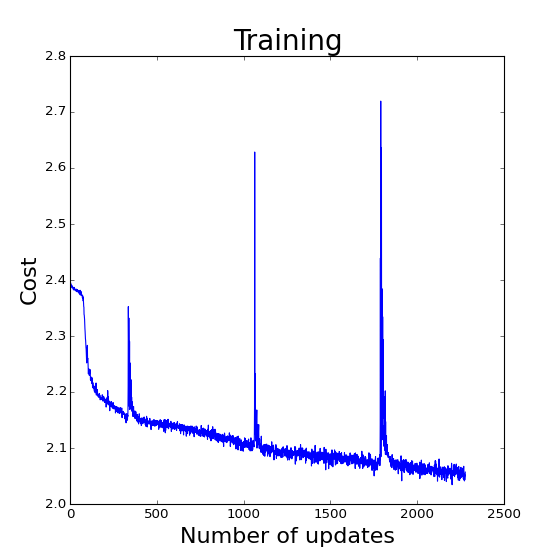

In [8]:
# plot training cost
plt.figure(figsize=(7,7))
plt.plot(costs)
plt.ylabel('Cost', fontsize=20)
plt.xlabel('Number of updates', fontsize=20)
plt.title('Training', fontsize=25)
plt.show()

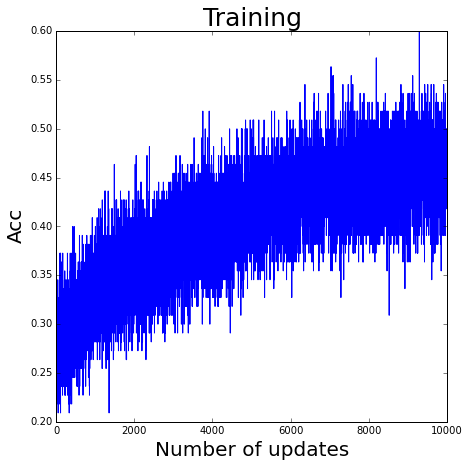

In [46]:
# plot training cost
plt.figure(figsize=(7,7))
plt.plot(accs)
plt.ylabel('Acc', fontsize=20)
plt.xlabel('Number of updates', fontsize=20)
plt.title('Training', fontsize=25)
plt.show()

Excercises:
1. Add support for different lengths of targets (hint: add the target_mask to the cost function and only calculate the cost for the non-masked targets)
2. Implement decaying learning rate (hint Make the learning rate a sumbolic variable and use it as input to the training function)
3. Add more layers to Encoder - two layers seems to be working weel on many real-life problems
4. Make the Encoder bidirectional (see hints below)
5. Make a Decoder with attention (see code below). Try to make a plot of the attention matrix alpha. **Note: The attention LSTM layer is currentlty not well documented**
6. Add dropout to the encoder, do you need a seperate function for evaluation now?


####2.  Bidirectional Encoder
In Lasagne bidirectional RNNs are implementated by running a forward model and a backward model separately and then concatenating them before parsing them on to the next layer. Remember to think about the number of hidden units before and after the concatenation

In [101]:
l_rec_fwd = lasagne.layers.GRULayer(...,backwards=False)
l_rec_bwd = lasagne.layers.GRULayer(...,backwards=True)
l_rec = lasagne.layers.ConcatLayer([l_rec_fwd, l_rec_bwd], axis=2))

SyntaxError: invalid syntax (<ipython-input-101-fe3b09099dca>, line 1)

####5. Attention Decoder (LSTM)

In [27]:
from decoder_attention import LSTMAttentionDecodeFeedbackLayer

BATCH_SIZE = 100
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10
MAX_DIGITS = 20 
MIN_DIGITS = MAX_DIGITS #currently only support for same length outputs - we'll leave it for an exercise to add support for varying length targets
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')


x_sym = T.imatrix()
y_sym = T.imatrix()
xmask_sym = T.matrix()

#dummy data to test implementation
#X = np.random.randint(0,10,size=(BATCH_SIZE,15)).astype('int32')
#Xmask = np.ones((BATCH_SIZE,NUM_INPUTS)).astype('float32')

l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
l_emb.params[l_emb.W].remove('trainable') 
#Here we'll remove the trainable parameters from the embeding layer to constrain 
#it to a simple "one-hot-encoding". You can experiment with removing this line

#print lasagne.layers.get_output(l_emb, x_sym).eval({x_sym: X}).shape

l_enc = lasagne.layers.GRULayer(l_emb, num_units=NUM_UNITS_ENC, name='GRUEncoder')
#print lasagne.layers.get_output(l_enc, x_sym, mask=xmask_sym).eval({x_sym: X, xmask_sym:Xmask}).shape

# slice last index of dimension 1
l_last_hid = lasagne.layers.SliceLayer(l_enc, indices=-1, axis=1)
####END OF ENCODER######


####START OF DECODER######
#note that the decoder have its own input layer, we'll use that to plug in the output 
#from the encoder later

l_in_dec = lasagne.layers.InputLayer(l_last_hid.output_shape) 
l_in_rep = RepeatLayer(l_in_dec, n=MAX_DIGITS+1) #we add one to allow space for the end of sequence character
l_dec = LSTMAttentionDecodeFeedbackLayer(l_in_rep,
                                        num_units=NUM_UNITS_DEC, 
                                        aln_num_units=100,
                                        n_decodesteps=MAX_DIGITS+1,
                                        name='LSTMDecoder')

# We need to do some reshape voodo to connect a softmax layer to the decoder.
# See http://lasagne.readthedocs.org/en/latest/modules/layers/recurrent.html#examples 

l_reshape = lasagne.layers.ReshapeLayer(l_dec, (-1, [2]))
#print lasagne.layers.get_output(l_reshape, x_sym).eval({x_sym: X}).shape
l_softmax = lasagne.layers.DenseLayer(l_reshape, num_units=NUM_OUTPUTS, 
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      name='SoftmaxOutput')
# print lasagne.layers.get_output(l_softmax, x_sym).eval({x_sym: X}).shape
# reshape back to 3d format (here we tied the batch size to the shape of the symbolic variable for X allowing 
#us to use different batch sizes in the model)
l_out = lasagne.layers.ReshapeLayer(l_softmax, (x_sym.shape[0], -1, NUM_OUTPUTS))
###END OF DECODER######

#get output of encoder using X and Xmask as input
output_encoder_train = lasagne.layers.get_output(l_last_hid, x_sym, mask=xmask_sym, deterministic=False,)
#get output of decoder using the encoder as input
output_decoder_train = lasagne.layers.get_output(l_out, output_encoder_train, deterministic=False)


#cost function
total_cost = T.nnet.categorical_crossentropy(
    T.reshape(output_decoder_train, (-1, NUM_OUTPUTS)), y_sym.flatten())
mean_cost = T.mean(total_cost)
#accuracy function
acc = T.mean(T.eq(T.argmax(output_decoder_train,axis=-1),y_sym))

#Get parameters of both encoder and decoder
all_parameters = lasagne.layers.get_all_params([l_last_hid, l_out], trainable=True)


print "Trainable Model Parameters"
print "-"*40
for param in all_parameters:
    print param, param.get_value().shape
print "-"*40

#Compile Theano functions
#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(mean_cost, all_parameters)]
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)
train_func = theano.function([x_sym, y_sym, xmask_sym], [mean_cost, acc, output_decoder_train], updates=updates)
#since we don't have any stochasticity in the network we will just use the training graph without any updates given
test_func = theano.function([x_sym, y_sym, xmask_sym], [acc, output_decoder_train])




Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (27, 10)
GRUEncoder.W_hid_to_updategate (10, 10)
GRUEncoder.b_updategate (10,)
GRUEncoder.W_in_to_resetgate (27, 10)
GRUEncoder.W_hid_to_resetgate (10, 10)
GRUEncoder.b_resetgate (10,)
GRUEncoder.W_in_to_hidden_update (27, 10)
GRUEncoder.W_hid_to_hidden_update (10, 10)
GRUEncoder.b_hidden_update (10,)
GRUEncoder.hid_init (1, 10)
LSTMDecoder.W_hid_to_ingate (10, 10)
LSTMDecoder.b_ingate (10,)
LSTMDecoder.W_hid_to_forgetgate (10, 10)
LSTMDecoder.b_forgetgate (10,)
LSTMDecoder.W_hid_to_cell (10, 10)
LSTMDecoder.b_cell (10,)
LSTMDecoder.W_hid_to_outgate (10, 10)
LSTMDecoder.b_outgate (10,)
LSTMDecoder.W_weightedhid_to_ingate (10, 10)
LSTMDecoder.W_weightedhid_to_forgetgate (10, 10)
LSTMDecoder.W_weightedhid_to_cell (10, 10)
LSTMDecoder.W_weightedhid_to_outgate (10, 10)
LSTMDecoder.W_cell_to_ingate (10,)
LSTMDecoder.W_cell_to_forgetgate (10,)
LSTMDecoder.W_cell_to_outgate (10,)
LSTMDecoder.Alig

In [ ]:
NUM_UPDATES = 100000
val_interval = 5000
samples_processed = 0
val_samples = []
costs, accs = [], []
plt.figure()
for n in range(NUM_UPDATES):
    inputs, input_masks, targets, target_masks, _, _ = \
        get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
    batch_cost, batch_acc, batch_output = train_func(inputs, targets, input_masks)
    costs += [batch_cost]
    samples_processed += BATCH_SIZE
    #print i, samples_processed
    #validation data
    if samples_processed % val_interval == 0:
        #print "validating"
        batch_acc, batch_output = test_func(Xval, Yval, Xmask_val)
        val_samples += [samples_processed]
        accs += [batch_acc]
        plt.plot(val_samples,accs)
        plt.ylabel('Val Acc', fontsize=20)
        plt.xlabel('Processed samples', fontsize=20)
        plt.title('Val ACC', fontsize=25)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.show()
        

<IPython.core.display.Javascript object>